In [1]:
import sys

sys.path += ["/Users/joosep/Documents/btv/SuperTagger/python/"]

import sklearn_cls
from sklearn_cls import evaluate_sklearn

import dask
from dask.dot import dot_graph
from dask.multiprocessing import get

import pandas
import root_numpy as rnpy

from sklearn.ensemble import GradientBoostingClassifier

import numpy as np

import cPickle

%matplotlib inline
import seaborn

ImportError: No module named sklearn_cls

In [2]:
cols_replacevals = {
    "Jet_CSV": {"replaceval_bad": 0, "replaceval_low": 0, "replaceval_high": 1},
    "Jet_CSVIVF": {"replaceval_bad": 0, "replaceval_low": 0, "replaceval_high": 1},
    "Jet_cMVA": {"replaceval_bad": -1, "replaceval_low": -1, "replaceval_high": 1},
    "Jet_JP": {"replaceval_bad": 0, "replaceval_low": 0, "replaceval_high": 5},
    "Jet_JBP": {"replaceval_bad": 0, "replaceval_low": 0, "replaceval_high": 15},
    "Jet_SoftMu": {"replaceval_bad": 0, "replaceval_low": 0, "replaceval_high": 1},
    "Jet_SoftEl": {"replaceval_bad": 0, "replaceval_low": 0, "replaceval_high": 1},
}

In [3]:
g = {
    "variables": (["Jet_CSV", "Jet_CSVIVF", "Jet_JP", "Jet_JBP", "Jet_SoftMu", "Jet_SoftEl"]),
    "load_data": (sklearn_cls.load_data, "/Users/joosep/Documents/btv/data/Oct4/qcd_1000_inf.root", "tagVars/ttree", 0, 10000, [
            "Jet_pt", "Jet_eta",
            "Jet_CSV", "Jet_CSVIVF",
            "Jet_cMVA",
            "Jet_JP", "Jet_JBP",
            "Jet_SoftMu", "Jet_SoftEl",
            "Jet_flavour"
        ],
        "Jet_pt>20"
    ),
    "preprocess": (sklearn_cls.preprocess, "load_data"),
    "normalize": (sklearn_cls.normalize_all_cols, "preprocess", cols_replacevals),
    "weighted_data": (sklearn_cls.calc_weight_binary, "normalize", "is_b"),
    "training_data": (sklearn_cls.filter_data, "weighted_data", "(is_training == 1)"),

    "classifier-1": (sklearn_cls.classifier, GradientBoostingClassifier, {"n_estimators": 100, "learning_rate": 0.1}),
    "fit_classifier_CV-1": (sklearn_cls.fit_classifier_CV, "classifier-1", "weighted_data", "variables", "is_b"),
    "fit_classifier-1": (sklearn_cls.fit_classifier, "classifier-1", "weighted_data", "variables", "is_b"),
    "evaluate_cls-1": (sklearn_cls.evaluate_cls, "fit_classifier-1", "preprocess", "variables"),

    "result": (sklearn_cls.make_tuple, "preprocess", "evaluate_cls-1", "fit_classifier_CV-1", "fit_classifier-1")
}

In [4]:
fi = open("graph.pickle", "w")
cPickle.dump(g, fi)
fi.close()

In [5]:
from dask.diagnostics import ProgressBar
ret = None
with ProgressBar():
    ret = get(g, "result")

[########################################] | 100% Completed |  3.4s


In [6]:
data, vals, res_cv, classifier = ret

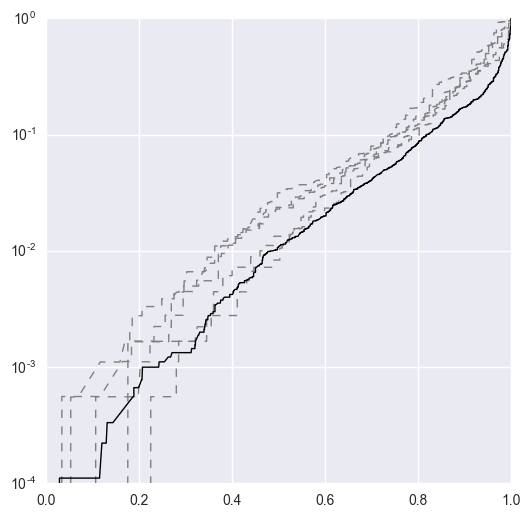

In [7]:
seaborn.plt.figure(figsize=(6,6))
for tpr, fpr in res_cv:
    seaborn.plt.plot(tpr, fpr, color="gray", lw=1, ls="--")
fpr, tpr, thresh = sklearn_cls.roc(classifier, data[["Jet_CSV", "Jet_CSVIVF", "Jet_JP", "Jet_JBP", "Jet_SoftMu", "Jet_SoftEl"]], data["is_b"])
seaborn.plt.plot(tpr, fpr, color="black", lw=1, ls="-")
seaborn.plt.yscale("log")